In [1]:
import cfgrib
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("..")

from baselines.data_processor import DataProcessor
from baselines.linear_reg.linear_regressor import LinearRegressor
# from baselines.baseline_regressor import BaselineRegressor

In [2]:
# https://github.com/ecmwf/cfgrib/issues/164
grib_data = cfgrib.open_datasets('../data2022.grib')
surface = grib_data[0] 
hybrid = grib_data[1] 

In [3]:
feature_list = ['t2m', 'tcc', 'u10', 'v10', 'tp', 'sp']
t2m = surface.t2m.to_numpy() - 273.15  # -> C
sp = surface.sp.to_numpy() / 100       # -> hPa
tcc = surface.tcc.to_numpy()
u10 = surface.u10.to_numpy()
v10 = surface.v10.to_numpy()
tp = hybrid.tp.to_numpy().reshape((-1,) + hybrid.tp.shape[2:])
data = np.stack((t2m, tcc, u10, v10, tp, sp), axis=-1)

In [4]:
# s -> AUTOREG_SEQUENCE_LENGTH (input_size)
# fh -> FORECASTING_HORIZON
# (X1,X2,...,Xs) -> (Ys+1,Ys+2,...,Ys+fh)
s = 3
fh = 3

processor = DataProcessor(data)
X, y = processor.preprocess(s, fh, use_neighbours=False)
X_train, X_test, y_train, y_test = processor.train_test_split(X, y)

In [5]:
X.shape, y.shape

((1427, 25, 45, 3, 6), (1427, 25, 45, 3, 6))

<LINEAR>
t2m => RMSE:  3.0811; SE: 0.021236236158887593; MAE: 2.645573603226947
tcc => RMSE:  0.28655; SE: 0.004023650164304812; MAE: 0.24057740852986448
u10 => RMSE:  2.12189; SE: 0.03133131333920161; MAE: 1.5945648221167956
v10 => RMSE:  3.12738; SE: 0.03780265510403561; MAE: 2.597748133316316
tp => RMSE:  0.00023; SE: 3.4905727160843135e-06; MAE: 0.00014497462707045258
sp => RMSE:  2.97688; SE: 0.3292276738945686; MAE: 2.2261741672555817


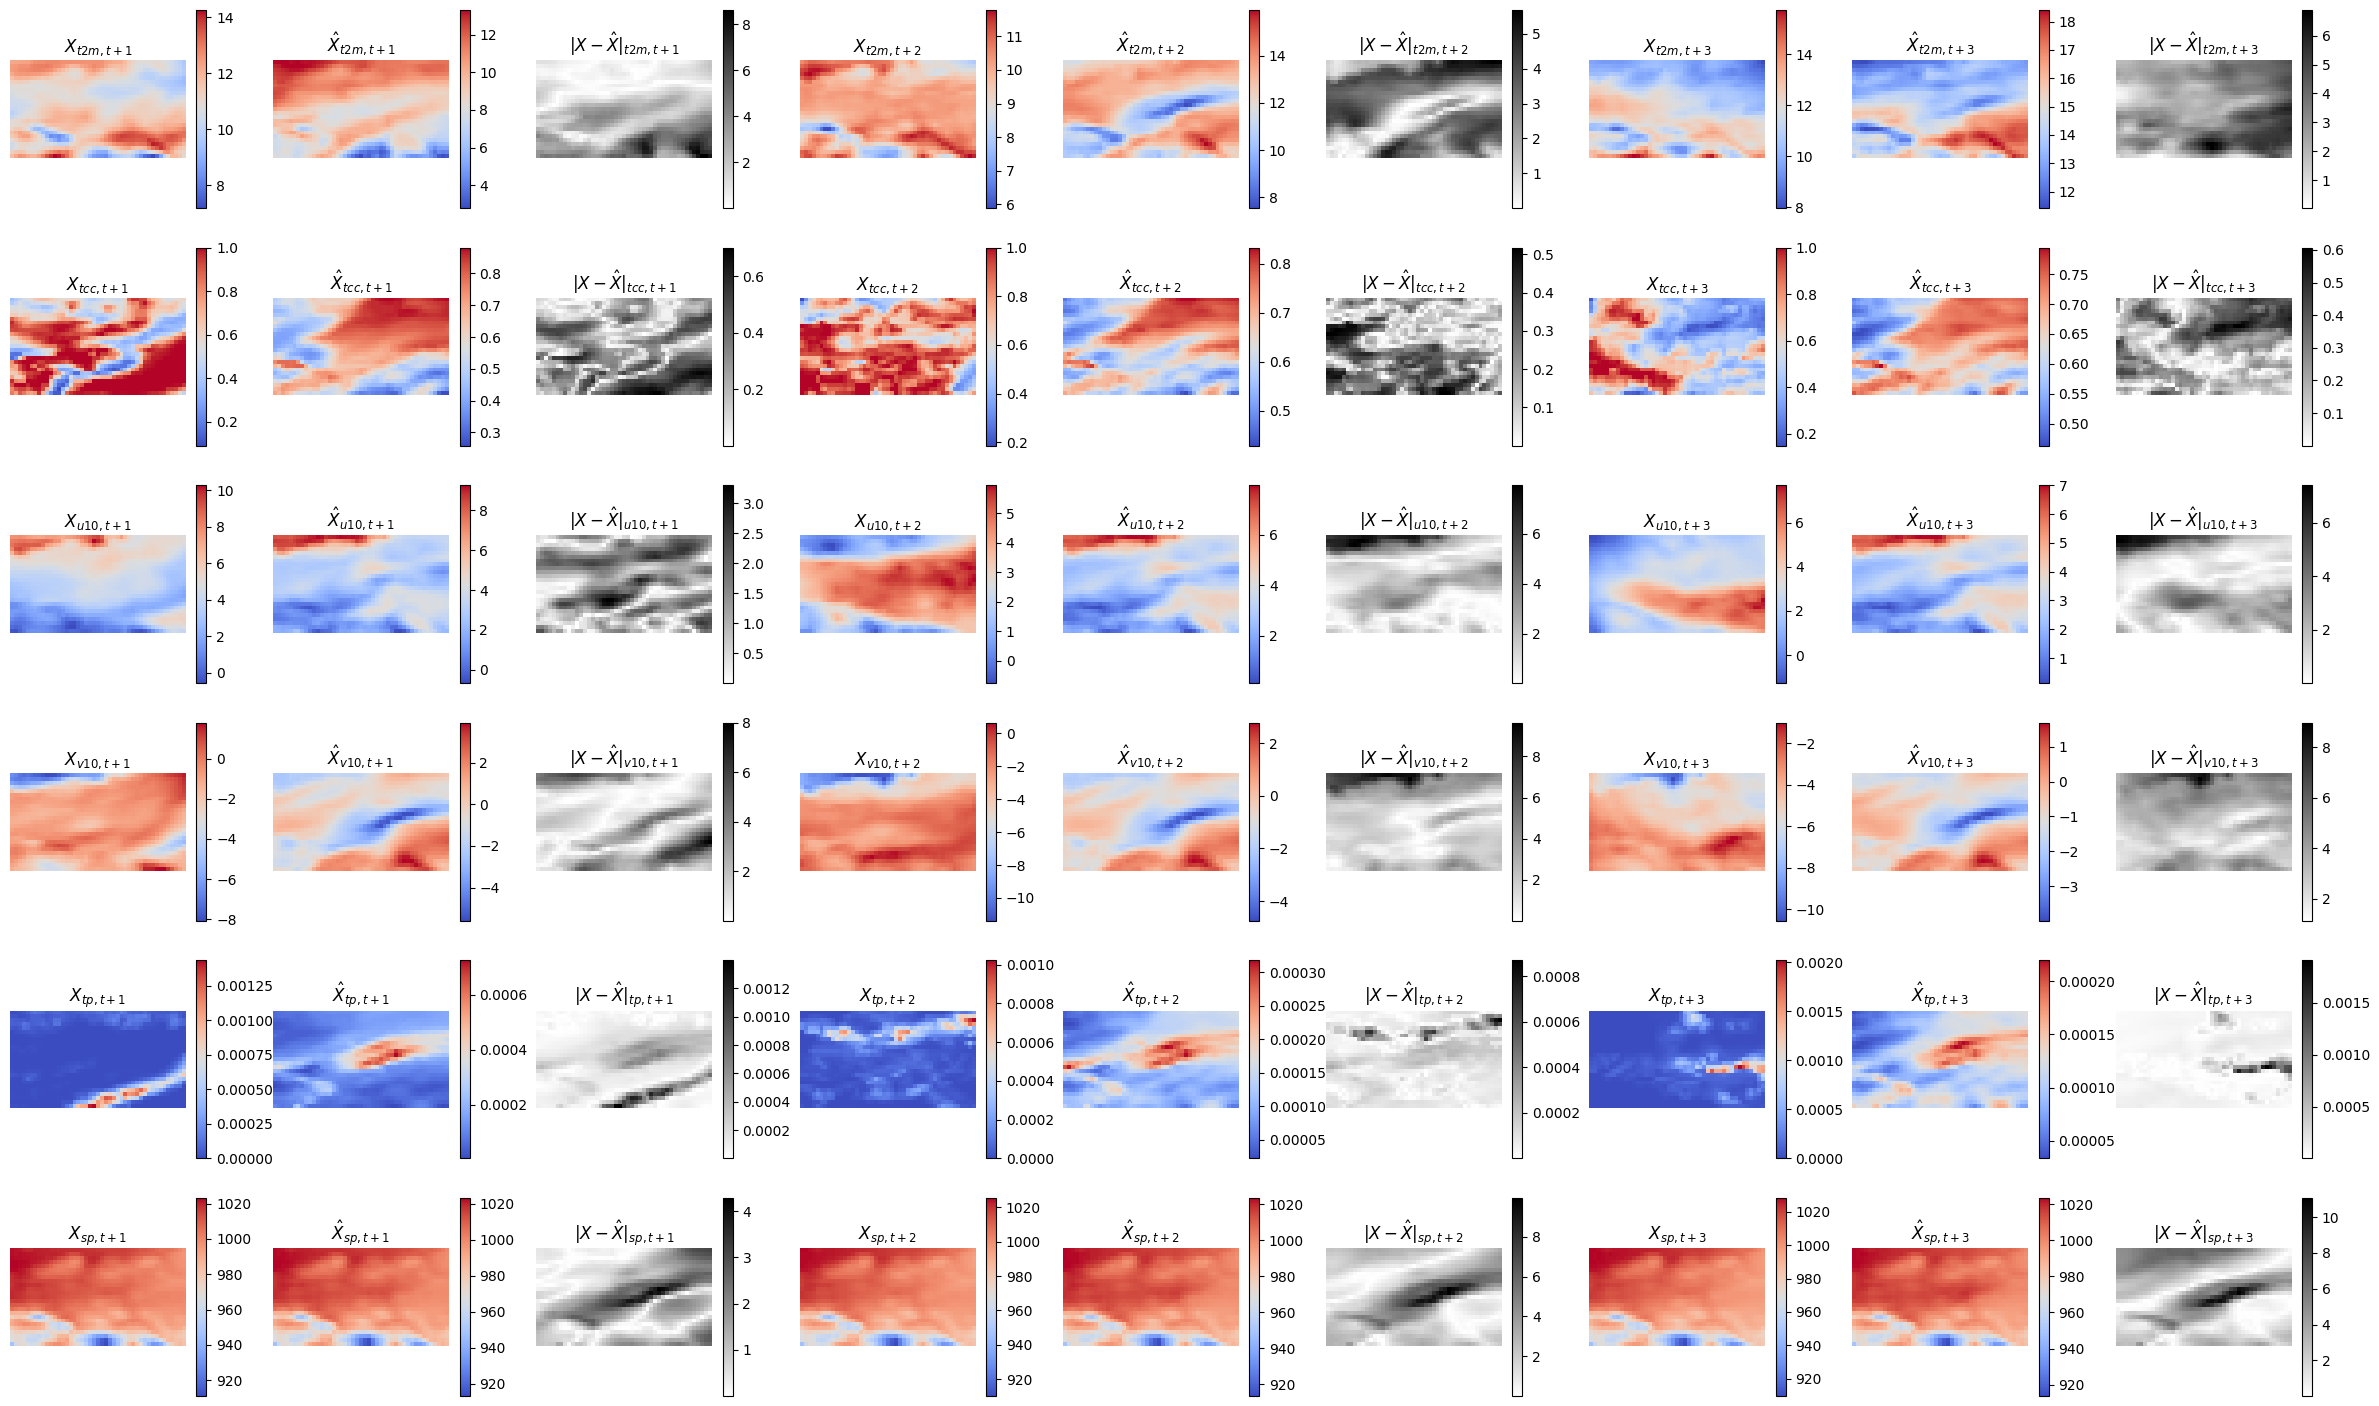

t2m => RMSE:  4.34971; SE: 0.03767641722630665; MAE: 3.9235450556786766
tcc => RMSE:  0.2829; SE: 0.004650385962049573; MAE: 0.23016207511459824
u10 => RMSE:  2.35776; SE: 0.03144977248222949; MAE: 1.8827437797082902
v10 => RMSE:  2.72154; SE: 0.031975464708389856; MAE: 2.3557368262193776
tp => RMSE:  0.00018; SE: 2.9783723564311807e-06; MAE: 0.00011446928241185282
sp => RMSE:  3.13002; SE: 0.33983002412503727; MAE: 2.420229937509598


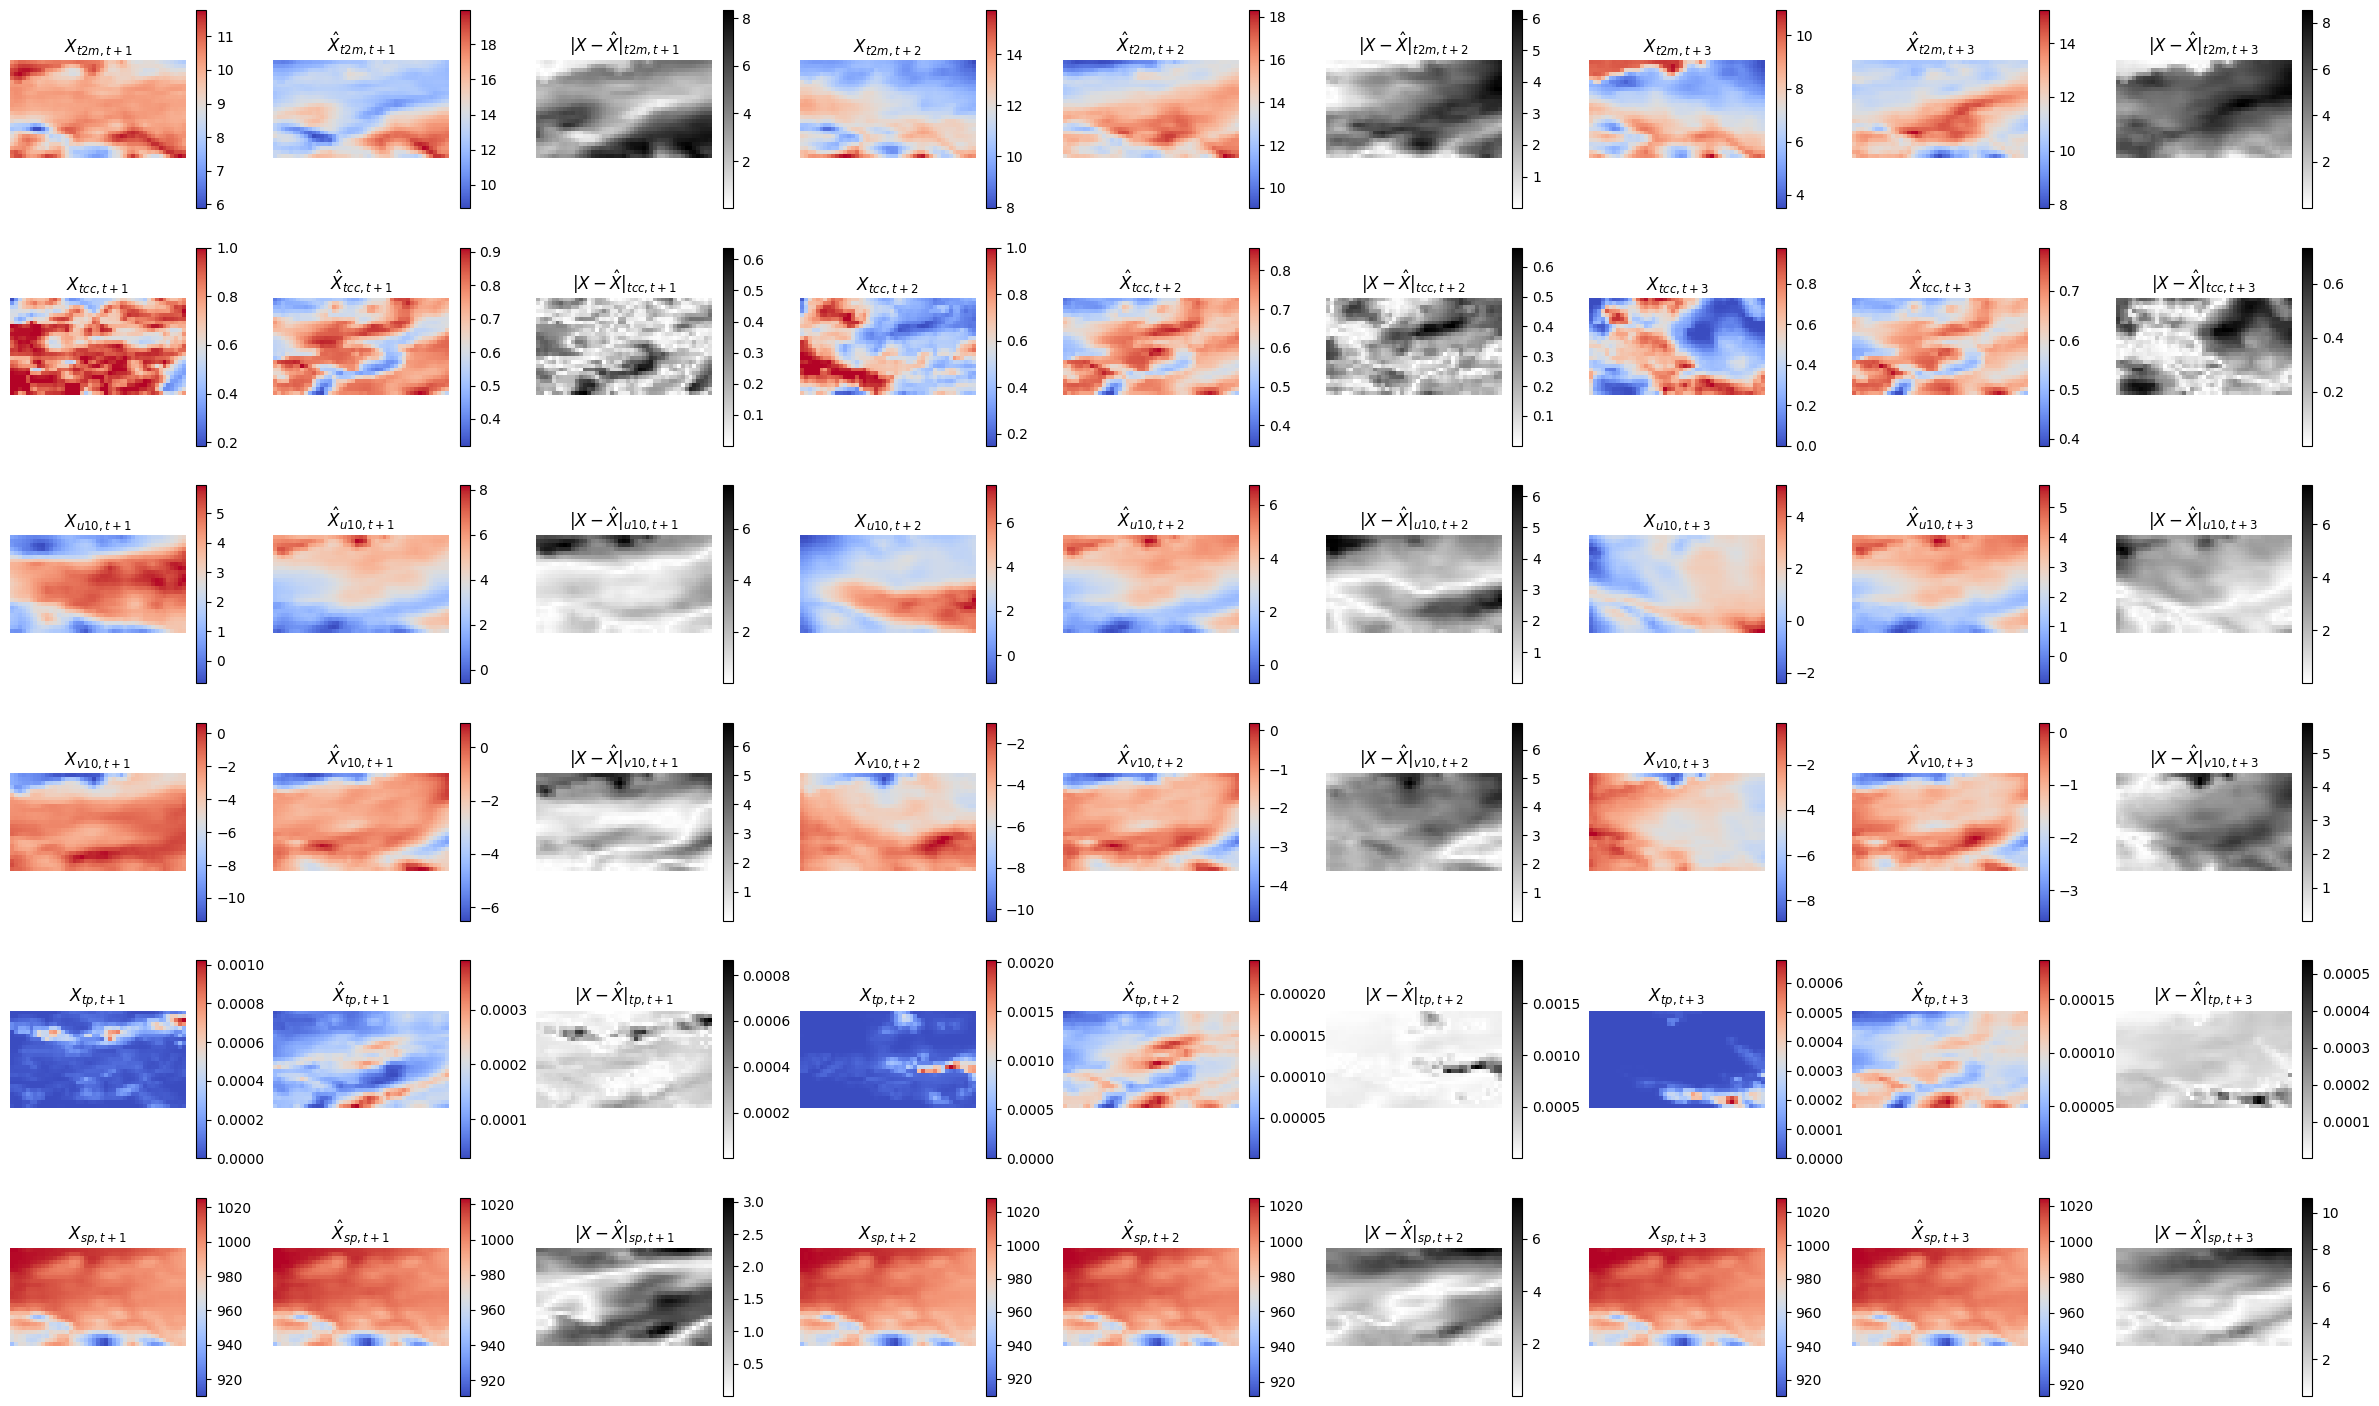

t2m => RMSE:  4.81701; SE: 0.062992411886668; MAE: 4.084920724048753
tcc => RMSE:  0.36309; SE: 0.004830684860869661; MAE: 0.30803190006843745
u10 => RMSE:  2.0208; SE: 0.03127624621560726; MAE: 1.6962882662552525
v10 => RMSE:  2.00711; SE: 0.03229404864894936; MAE: 1.6939841596001863
tp => RMSE:  0.00016; SE: 2.6858246130952438e-06; MAE: 0.00010449781997108753
sp => RMSE:  3.76729; SE: 0.3470438959062069; MAE: 2.9604204851927656


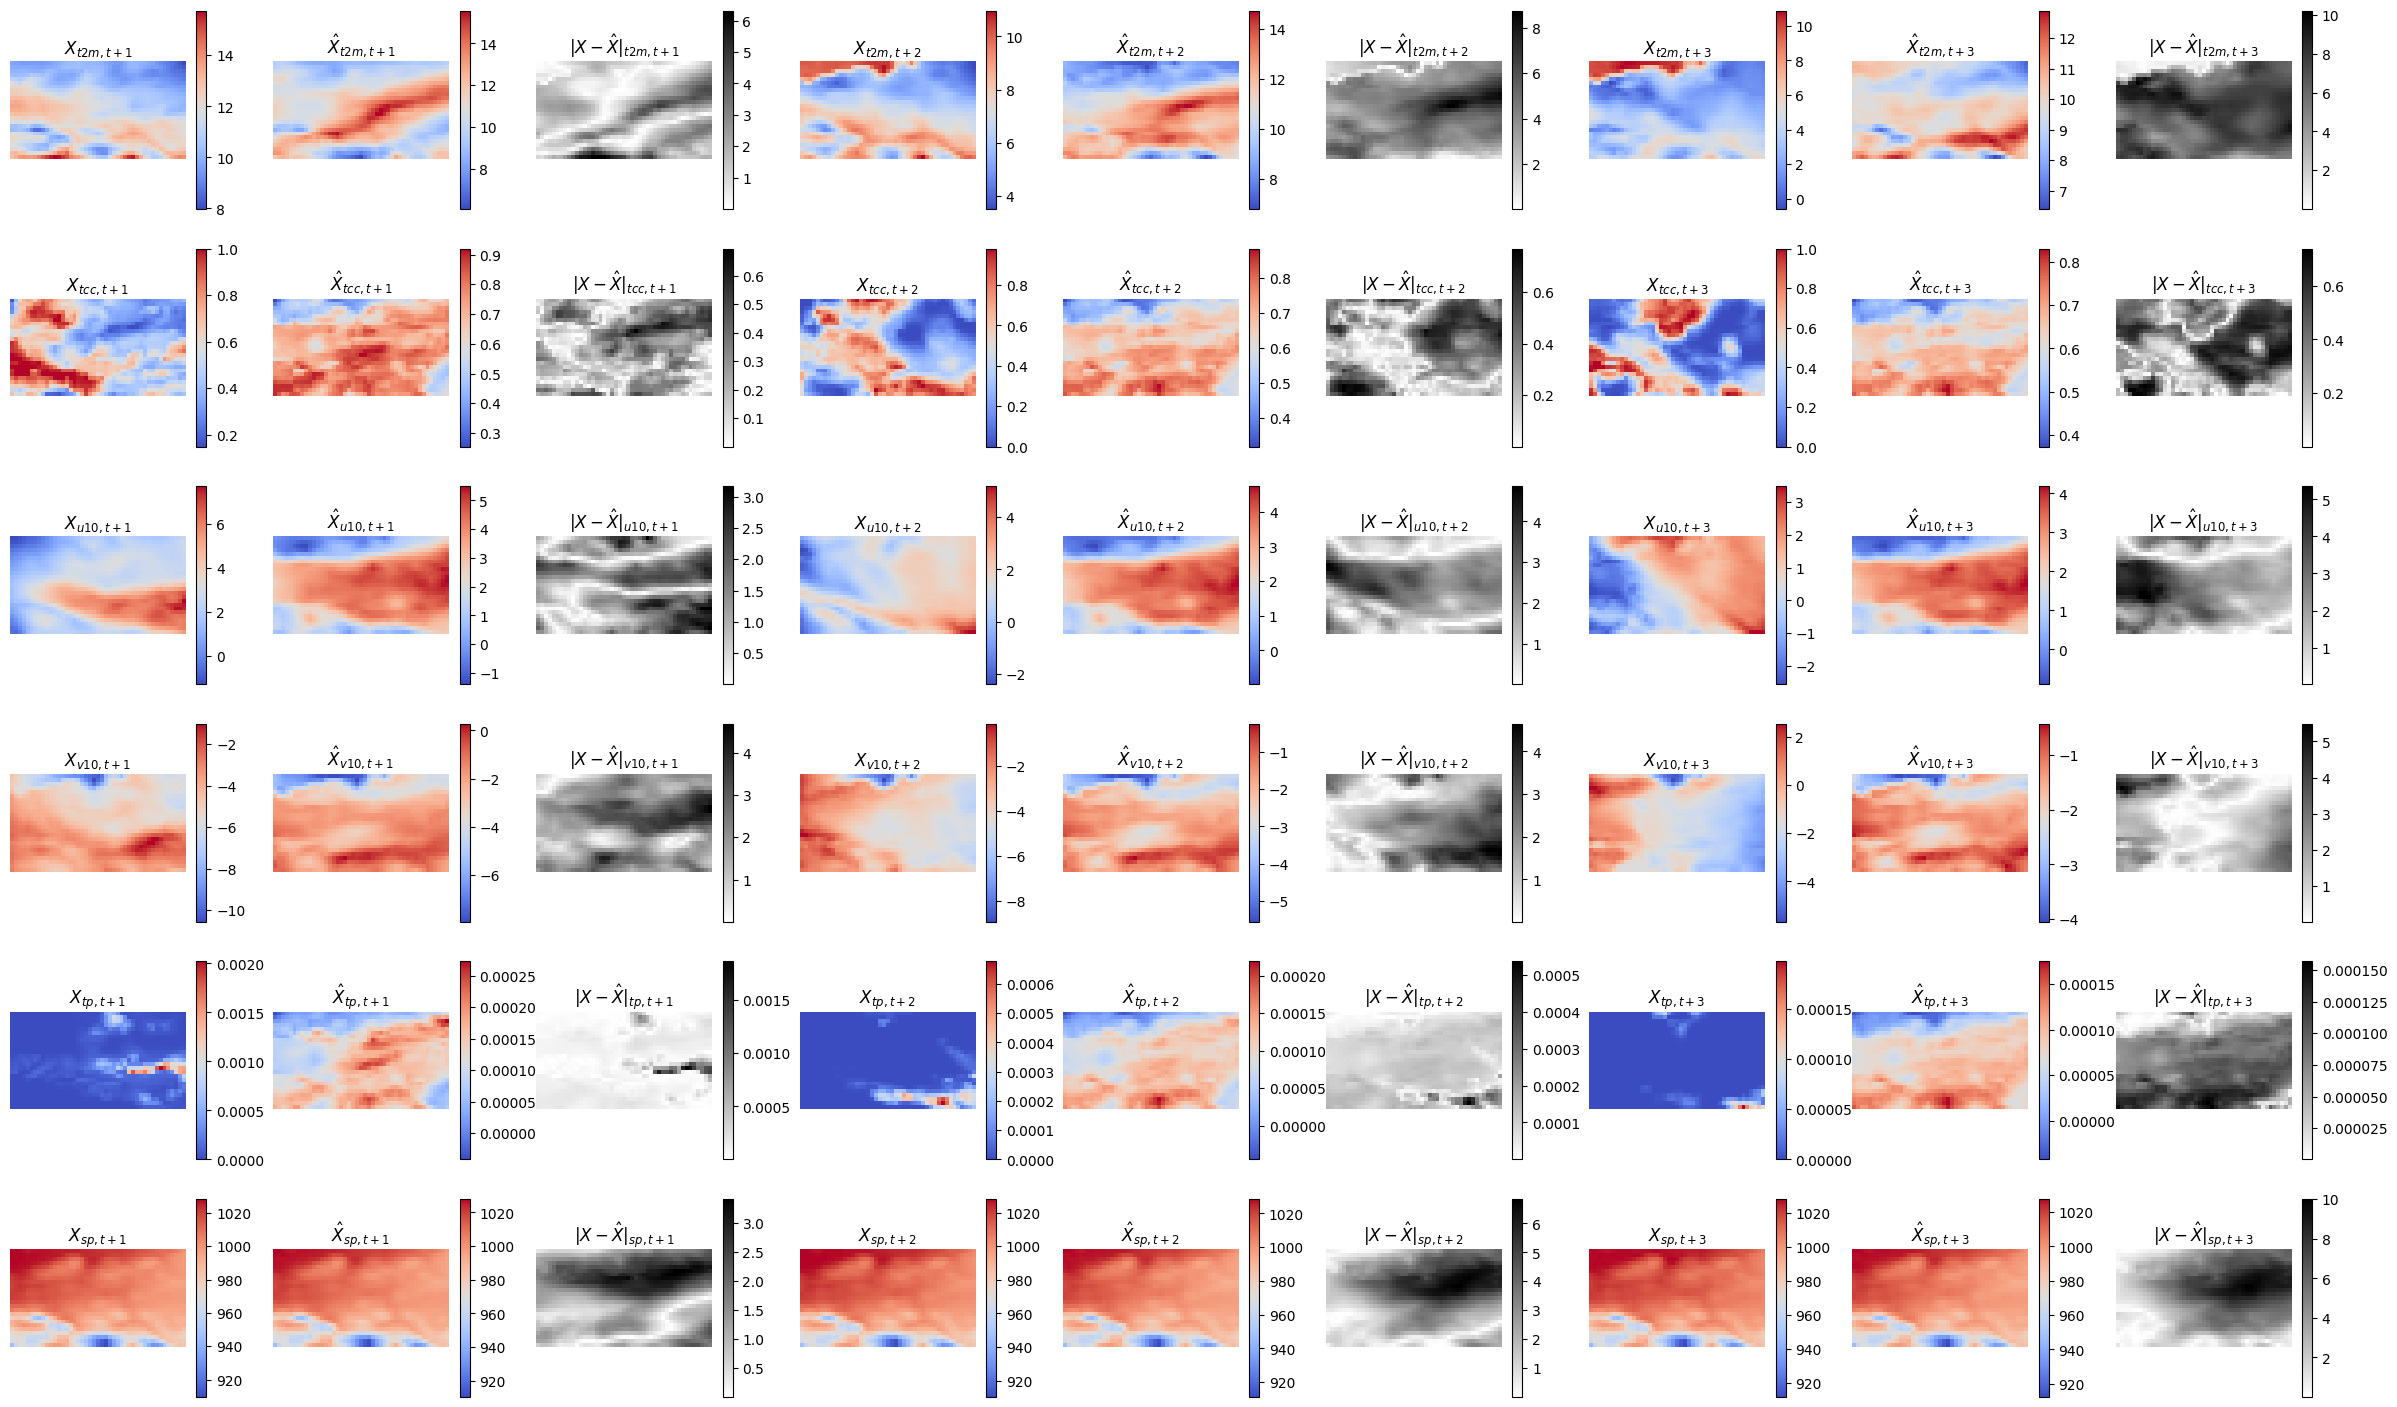

Evaluation metrics for entire test set:
t2m => RMSE: 2.625; SE: 0.005901756074861131; MAE: 2.009
tcc => RMSE: 0.288; SE: 0.0002772875764415203; MAE: 0.25
u10 => RMSE: 2.04; SE: 0.002905309043208137; MAE: 1.573
v10 => RMSE: 1.709; SE: 0.0023799655932334822; MAE: 1.31
tp => RMSE: 0.0; SE: 2.0052221260247116e-07; MAE: 0.0
sp => RMSE: 2.736; SE: 0.02138352719199003; MAE: 1.964


 23.5591459274292 [S]


In [6]:
from time import time 
start = time()

available_reg = ['linear']
for reg in available_reg:
    print(f'<{reg.upper()}>')
    # linearreg = BaselineRegressor(X.shape, fh, feature_list)
    linearreg = LinearRegressor(X.shape, fh, feature_list, regressor_type=reg)
    linearreg.train(X_train, y_train)
    _ = linearreg.predict_and_evaluate(X_test, y_test, max_samples=3)
    print()
    
stop = time()
print('\n', stop-start, '[S]')

In [10]:
s = 3
fh = 3

processor = DataProcessor(data)
X, y = processor.preprocess(s, fh, use_neighbours=True)
X_train, X_test, y_train, y_test = processor.train_test_split(X, y)

<LINEAR>
t2m => RMSE:  8.32285; SE: 0.021236236158887593; MAE: 4.6518456522582285
tcc => RMSE:  0.52925; SE: 0.004023650164304812; MAE: 0.362422443461002
u10 => RMSE:  16.5549; SE: 0.03133131333920161; MAE: 6.979718950385807
v10 => RMSE:  17.75844; SE: 0.03780265510403561; MAE: 8.314887970513624
tp => RMSE:  0.00103; SE: 3.4905727160843135e-06; MAE: 0.0005297544680394634
sp => RMSE:  33.13412; SE: 0.3292276738945686; MAE: 15.337549891314225


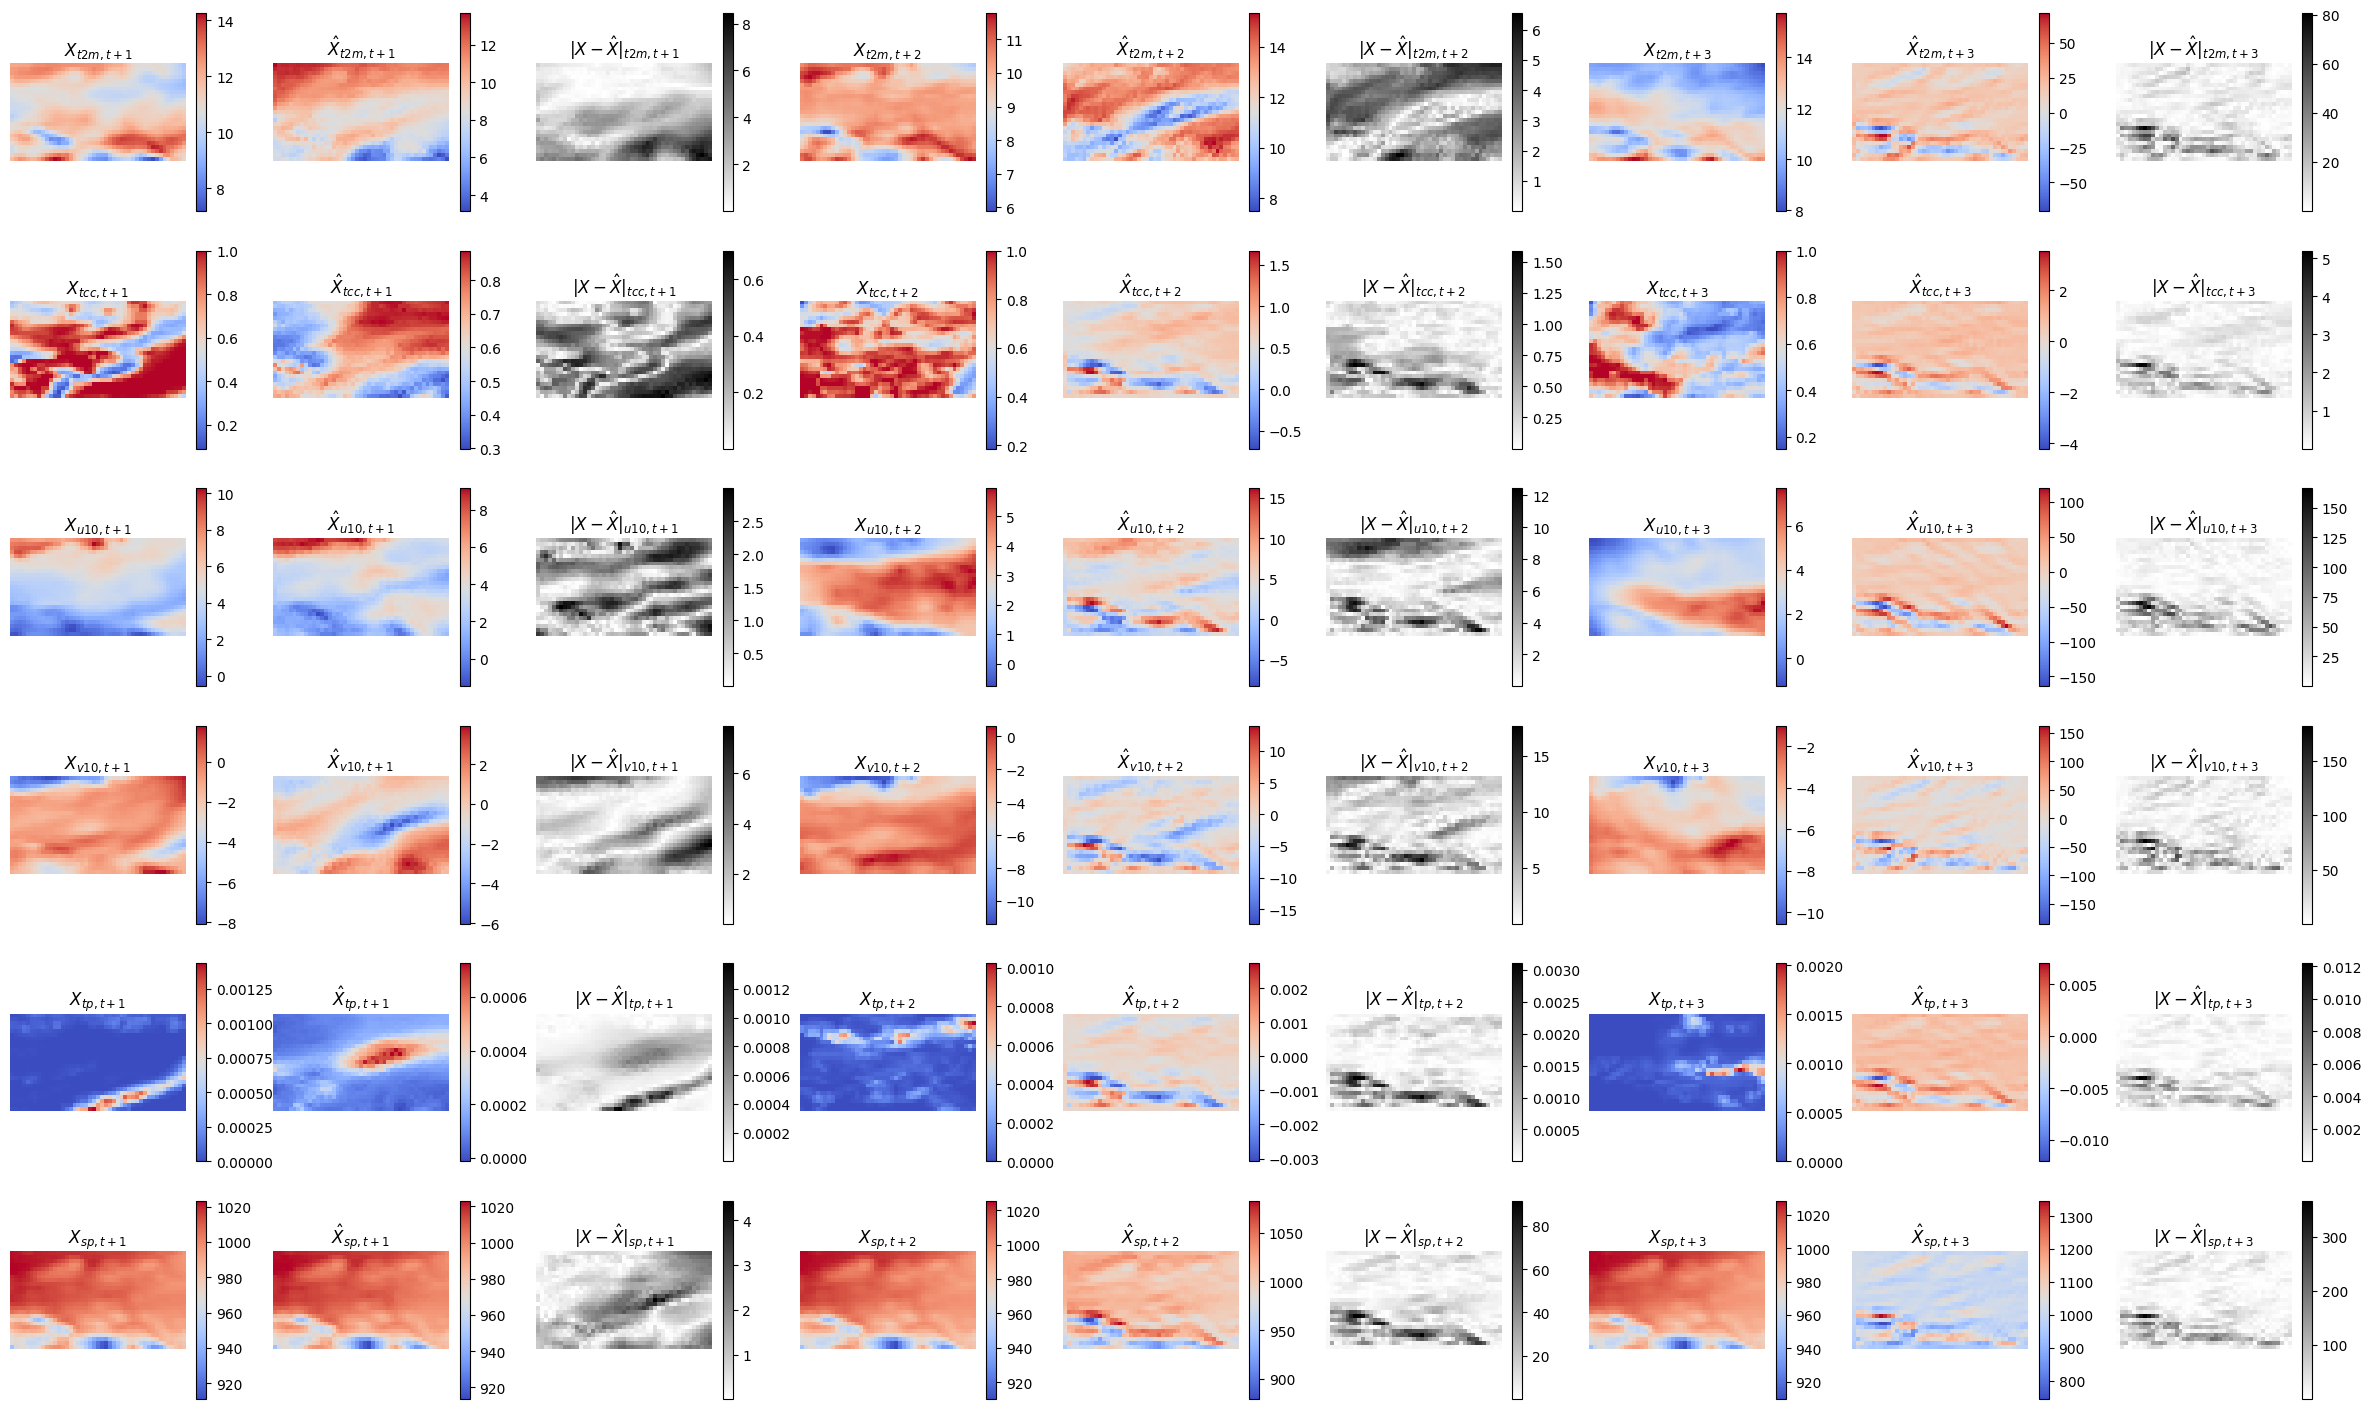

Evaluation metrics for entire test set:
t2m => RMSE: 8.591; SE: 0.005901756074861133; MAE: 4.319
tcc => RMSE: 0.513; SE: 0.00027728757644152025; MAE: 0.349
u10 => RMSE: 16.969; SE: 0.002905309043208137; MAE: 6.947
v10 => RMSE: 18.073; SE: 0.0023799655932334814; MAE: 7.623
tp => RMSE: 0.001; SE: 2.005222126024712e-07; MAE: 0.0
sp => RMSE: 33.591; SE: 0.021383527191990027; MAE: 15.085


 77.52261090278625 [S]


In [11]:
start = time()

available_reg = ['linear']
for reg in available_reg:
    print(f'<{reg.upper()}>')
    # linearreg = BaselineRegressor(X.shape, fh, feature_list)
    linearreg = LinearRegressor(X.shape, fh, feature_list, regressor_type=reg)
    linearreg.train(X_train, y_train)
    _ = linearreg.predict_and_evaluate(X_test, y_test, max_samples=1)
    print()
    
stop = time()
print('\n', stop-start, '[S]')